# MSCF 46982 Market Microstructure and Algorithmic Trading
# Fall 2025 Mini 2

Before you turn this assignment in, make sure everything runs as
expected. First, **restart the kernel**: by selecting
Kernel$\rightarrow$Restart Kernel from the menubar (or the `0,0`
keyboard shortcut) and then **run all cells** by selecting
Run$\rightarrow$Run All Cells from the menubar.

Make sure you replace all instances `YOUR CODE HERE` or "YOUR ANSWER
HERE" with your solution and remove the `notimplemented` exception.


As indicated in the syllabus, you are encouraged to discuss the
material presented in class but not of the specifics of assignments
(including this one).


---

In [1]:
import os
os.environ['PYKX_JUPYTERQ'] = 'true'
os.environ['PYKX_4_1_ENABLED'] = 'true'
import pykx as kx


<frozen importlib._bootstrap>:488: PyKXWarning: Unable to connect user QHOME to PyKX QHOME via symlinks.
To permanently disable attempts to create symlinks you can
	1. Set the environment variable "PYKX_IGNORE_QHOME" = True.
	2. Update the file ".pykx-config" using kx.util.add_to_config({'PYKX_IGNORE_QHOME': 'True'})
Error: [WinError 1314] A required privilege is not held by the client: 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\Mkt Micro and Algo\\cmu_userpass.txt' -> 'C:\\Users\\jacob\\Desktop\\Fin Computing I\\env\\Lib\\site-packages\\pykx\\lib\\4-1-libs\\cmu_userpass.txt'



PyKX now running in 'jupyter_qfirst' mode. All cells by default will be run as q code. 
Include '%%py' at the beginning of each cell to run as python code. 


## Volatility, Volume, Spread and Quote Profiles

Electronic trading algorithms benchmarked to arrival price face a
tradeoff of executing immediately with the risk of having market
impact, or executing slowly with the risk of executing at a bad price
as the market moves away.


To properly balance these tradeoffs, the algo must have an estimate
about the shape of the intraday spread, volatility, volume and quote
size profiles.


This assignment uses actual data from [NYSE Daily TAQ][] to
generate these estimates.

[NYSE Daily TAQ]:
http://www.nyxdata.com/Data-Products/Daily-TAQ "NYSE Daily TAQ"


We start by opening a connection to the NYSE Daily TAQ database. The
symbol saved in `h` is a Kdb+ file handle.  It will be used for all
database communication.

NOTE: The database is located on a CMU server - behind the firewall.
If you are doing this assignment from home, you will need to connect to
the CMU network using the [Cisco AnyConnect VPN][] software.

[Cisco AnyConnect VPN]:
https://www.cmu.edu/computing/services/endpoint/network-access/vpn/index.html
"Cisco AnyConnect VPN"


In [2]:
\c 5 100

/ windows and mac/linux use different environment variables
home:`HOME`USERPROFILE "w"=first string .z.o
upf:0N!` sv (hsym`$getenv home),`cmu_userpass.txt
h:`$":tcps://tpr-mscf-kx.tepper.cmu.edu:5000:",first read0 upf


### Part A (2 Points)

Complete the `tradequery` function so that it selects trade
information for a single stock across multiple days for the given time
range and trade conditions.

Given a start date, end date, start time, end time, symbol(s) and
string of desired trade conditions, return a table with all the
columns from the `trade` table.


In [3]:
/ (s)tart (d)ate, (e)nd (d)ate, (s)tart (t)ime, (e)nd (t)ime, (s)ym, trade (c)ondition codes
tradequery:{[sd;ed;st;et;s;c]
 t:select from trade where date within(sd;ed),sym in s,time within(st;et),cond in c;
 t}

In [4]:
/ pass function to database for execution
h (tradequery;2020.02.03;2020.02.03;09:30;09:35;`BAC;" ")

date       sym time                 price  size stop cond ex
------------------------------------------------------------
2020.02.03 BAC 0D09:30:00.817811754 33.005 100  0         V 
2020.02.03 BAC 0D09:30:00.866722736 33     100  0         Y 
2020.02.03 BAC 0D09:30:00.894893840 33.005 100  0         D 
2020.02.03 BAC 0D09:30:00.928327524 33     100  0         Y 
2020.02.03 BAC 0D09:30:01.227020933 33     400  0         N 
..


In [5]:
rnd:{x*"j"$y%x}
assert:{if[not x~y;'"expecting '",(-3!x),"' but found '",(-3!y),"'"]}
/ confirm all columns are included
assert[`date`sym`time`price`size`stop`cond`ex] cols h (tradequery;2020.02.01;2020.02.01;09:30;16:00;`BAC;"O")
/ confirm query only selects specified dates
assert[2] count exec distinct date from h (tradequery;2020.02.03;2020.02.04;09:30;16:00;`BAC;"O")
/ confirm only requested sym has been returned
assert[1#`BAC] exec distinct sym from h (tradequery;2020.02.03;2020.02.03;09:30;16:00;`BAC;"O")
assert[`BAC`TSLA] exec distinct sym from h (tradequery;2020.02.03;2020.02.03;09:30;16:00;`BAC`TSLA;"O")
/ confirm only data within the expected time range is returned
assert[1b] all within[;09:30 16:00]exec time from h (tradequery;2020.02.03;2020.02.03;09:30;16:00;`BAC;"O")
assert[1b] all within[;09:30 12:00]exec time from h (tradequery;2020.02.03;2020.02.03;09:30;12:00;`BAC;"O")
/ confirm only selected condition codes have been returned
assert[1#"O"] exec distinct cond from h (tradequery;2020.02.03;2020.02.03;09:30;16:00;`BAC;"O")
assert[" O"] exec asc distinct cond from h (tradequery;2020.02.03;2020.02.03;09:30;16:00;`BAC;" O")

In [6]:
timeit:{[f;x]system "ts ", last[get f],"[",(1_-1_-3!x),"]"}
/ check that the function is implemented efficiently
assert[1b] 7441856>=0N!last h (timeit;tradequery;(2020.02.03;2020.02.03;09:30;16:00;`BAC;" O"))

### Part B (2 Points)

Before computing a volatility profile, lets get some practice
aggregating the data over multiple dates.

Similar to the technique used in homework 2, we will compute the high
and low prices within each minute of each date.

Complete the `hl` function which creates two columns `h` and `l` with
the max and min prices within each minute of each date.

The resulting table should have five columns (`date`, `sym`, `time`,
`h` and `l`) and 3900 rows - one for each minute of each symbol of
each day


In [7]:
sym:`BAC`TSLA
/ we will only use use data from the 1st through the 10th
/ while this is not a lot of trade data, you will see in the last question
/ that even loading this amount of data takes a long time and uses a few Gb of memory
sd:2020.02.01;ed:2020.02.10
st:09:30;et:16:00
t:h (tradequery;sd;ed;st;et;sym;" ")

In [8]:
hl:{[t]
 t:select h:max price,l:min price by date, sym, time:0D00:01 xbar time from t;
 t}

In [9]:
show highlow:hl t

In [10]:
/ confirm all columns are included
assert[`date`sym`time`h`l] cols highlow
/ confirm correct number of rows
assert[4680] count highlow
/ confirm correct schema
assert["dsnff"] value[meta highlow]`t
/ confirm there are 390 minutes in a trading day
assert[390] count distinct key[highlow]`time
/ confirm the high low calculations
assert[`h`l!407.63 405.66] rnd[.01] avg each flip value highlow

### Part C (2 Points)

With the practice behind us, we can move on to computing an intraday
volatility profile. Complete the `volatilityprofile` function which:

1. Summarizes the high and low prices within each minute of each
   date/symbol into columns `h` and `l`.
2. Uses the `parkinson` measure and the `h` and `l` columns to add a
   `variance` column.
3. Averages each sym/minute's variance across dates.
4. Adds a `volatility` column with the annualized volatility.
5. Returns a table with three columns (time, sym and volatility) and
   780 rows - one for each sym/minute


In [11]:
parkinson:{[h;l](1f%4f*log 2f)*r*r:log h%l}
/ given a table t (which is expected to have the columns `date`time`price)
/ generate a minutely volatility profile
volatilityprofile:{[t]
 t:select h:max price, l:min price by date, sym, time:0D00:01 xbar time from t;
 t:update variance:parkinson[h;l] from t;
 t:select avg variance by time, sym from t;
 t:update volatility:sqrt[variance*252*390] from t;
 t:delete variance from t;
 t}

In [12]:
/ build a volatility profile
show vp:volatilityprofile t
/ create pivot (t)able with data from the last column
/ pivot columns from the last key column
/ and pivot keys as all but the last key column
pivot:{[t]
 u:`$string asc distinct last f:flip key t;
 pf:{x#(`$string y)!z};
 p:?[t;();g!g:-1_ k;(pf;`u;last k:key f;last key flip value t)];
 p}
/ save the pivoted table for plotting
.pykx.set[`vp] .pykx.topd pivot vp

In [13]:
/ confirm all columns are included
assert[`time`sym`volatility] cols vp
/ confirm the table schema is correct
assert["nsf"] value[meta vp]`t
/ confirm the table row count is correct
assert[780] count vp
/ confirm there are 390 minutes in a trading day
assert[390] count distinct key[vp]`time
/ confirm the computed volatility profile calculations
assert[0.6014] rnd[1e-4] avg value[vp]`volatility

<Axes: title={'center': 'Volatility Profile'}, xlabel='time'>

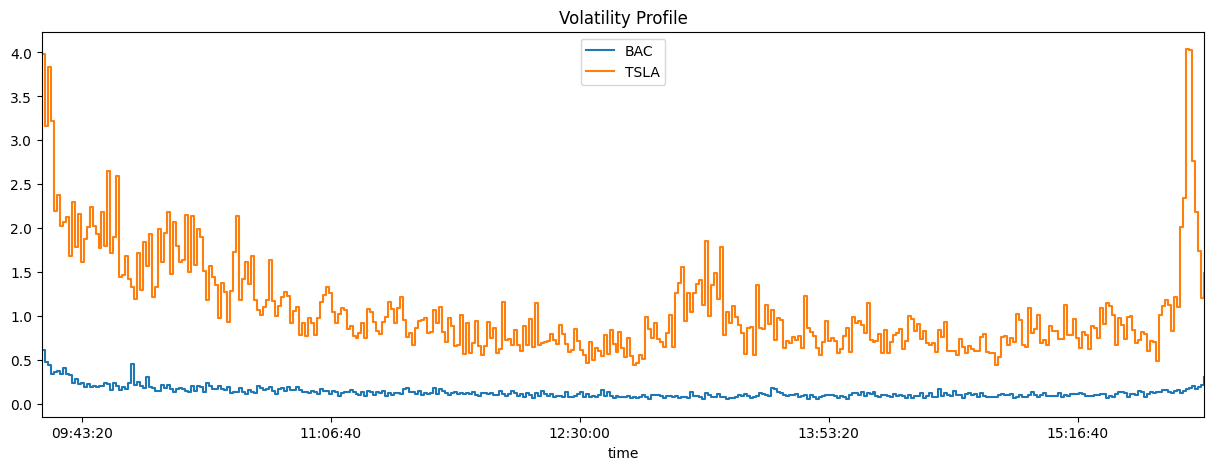

In [14]:
%%py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('default')
mpl.rcParams["figure.figsize"] = [15,5]
vp.plot(drawstyle='steps-post',title='Volatility Profile')


### Part D (2 Points)

Using the trading data complete the function `volumeprofile` which:

1. Aggregates the volume (size column) within each minute/sym of each
   date.
2. To make the values comparable across stocks and days with corporate
   actions, convert the volumes into percentages of the total daily
   volume: i.e., divide each minutes volume by the total volume for that
   date.
3. Averages each minute/sym's percentages across dates.
4. Returns a table with three columns (time, sym and percent) and
   780 rows - one for each minute/sym.


In [15]:
/ given a table t (which is expected to have the columns `date`time`size)
/ generate a minutely volume profile
volumeprofile:{[t]
 t:select volume:sum size by date, sym, time:0D00:01 xbar time from t;
 t:update percent:volume%sum volume by date, sym from t;
 t:select avg percent by time, sym from t;
 t}

In [16]:
/ build a volume profile
.pykx.set[`v] .pykx.topd  pivot v:volumeprofile t
show v


In [17]:
/ confirm all columns are included
assert[`time`sym`percent] cols v
/ confirm the table schema is correct
assert["nsf"] value[meta v]`t
/ confirm the table row count is correct
assert[780] count v
/ confirm there are 390 minutes in a day
assert[390] count distinct key[v]`time
/ confirm the computed volume profile calculations
assert[2f] rnd[.01] sum value[v]`percent

In [18]:
/ check that the function is implemented efficiently
assert[1b] 58726624>=0N!last system"ts volumeprofile t"

<Axes: title={'center': 'Volume Profile'}, xlabel='time'>

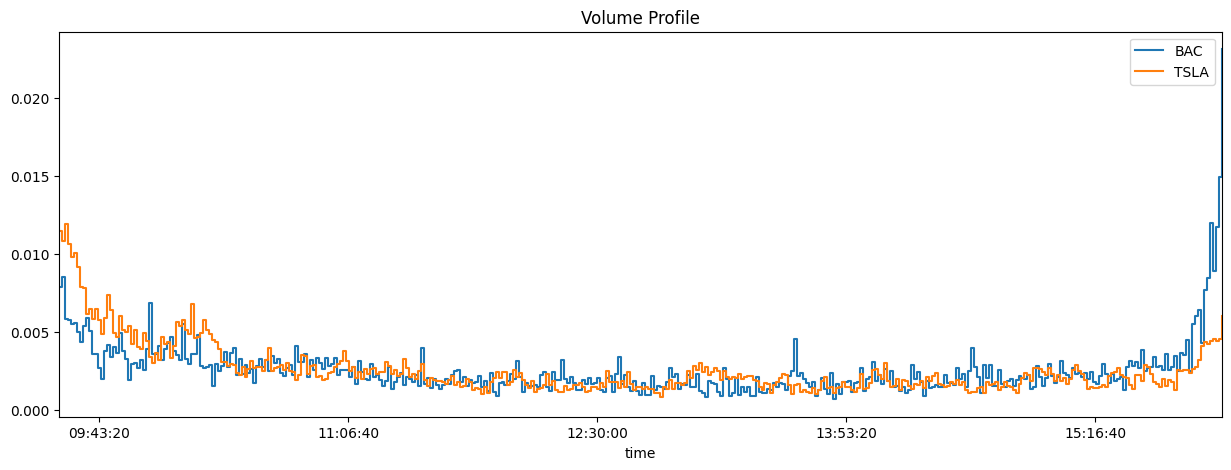

In [19]:
%%py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
v.plot(drawstyle='steps-post',title='Volume Profile')


### Part E (3 Points)

Again, using the trade data, we can compute the effective spread with
Roll's formula. Roll's paper defines a variant of the estimate that
computes the spread as a percentage. Percentage spreads can be compared
across securities and days without needing to adjust for corporate actions.

$$
\hat{s_{j,t}} = 200 \sqrt{-\hat{c_{j,t}}}
$$

Complete the `rollpct` function which:
1. Converts the passed-in prices to **log** returns
2. Calculates two times the `sqrt` of the negative **sample** covariance between the returns and the previous returns
3. Converts the results into percentages by multiplying by 100 


In [20]:
/ given prices as the argument (x), compute the roll effective spread as a percentage of the trade price
rollpct:{[x]
 200*sqrt neg x scov prev x:x - prev x:log x}

In [21]:
/ confirm an empty list returns an empty list
assert[()] rollpct ()
/ confirm a list of zeros returns null
assert[0n] rollpct 10#0
/ confirm positive autocorrelation returns null
assert[0n] rollpct 1+til 10
/ confirm negative autocorrelation returns the proper value
assert[4.28] rnd[.01] rollpct 10+10#-.1 .1
assert[.05] rnd[.01] rollpct t`price

In [22]:
/ check that the function is implemented efficiently
assert[1b] 33554976>=0N!last system"ts rollpct t`price"

### Part F (2 Points)

We can now use the `rollpct` function to compare spreads across securities.

Complete the `rspreadprofile` function which:
1. Uses Roll's percent spread formula to compute the effective percent
   spread within each minute/sym of each date.
2. Averages each minute's spread across date/syms.
3. Returns a table with three columns (time, sym and spread) and 780
   rows - one for each minute/sym.


In [23]:
/ given a table t (which is expected to have the columns `date`time`price)
/ generate a minutely spread profile
rspreadprofile:{[t]
 t:select spread:rollpct price by date, sym, time:0D00:01 xbar time from t;
 t:select avg spread by time, sym from t;
 t}

In [24]:
/ build a roll spread profile
.pykx.set[`rp] .pykx.topd pivot rp:rspreadprofile t
show rp

In [25]:
/ confirm all columns are included
assert[`time`sym`spread] cols rp
/ confirm the table schema is correct
assert["nsf"] value[meta rp]`t
/ confirm the table row count is correct
assert[780] count rp
/ confirm there are 390 minutes in a day
assert[390] count distinct key[rp]`time
/ confirm the computed spread profile calculations
assert[0.030775] rnd[1e-6] avg value[rp]`spread

<Axes: title={'center': 'Roll Percent Spread Profile'}, xlabel='time'>

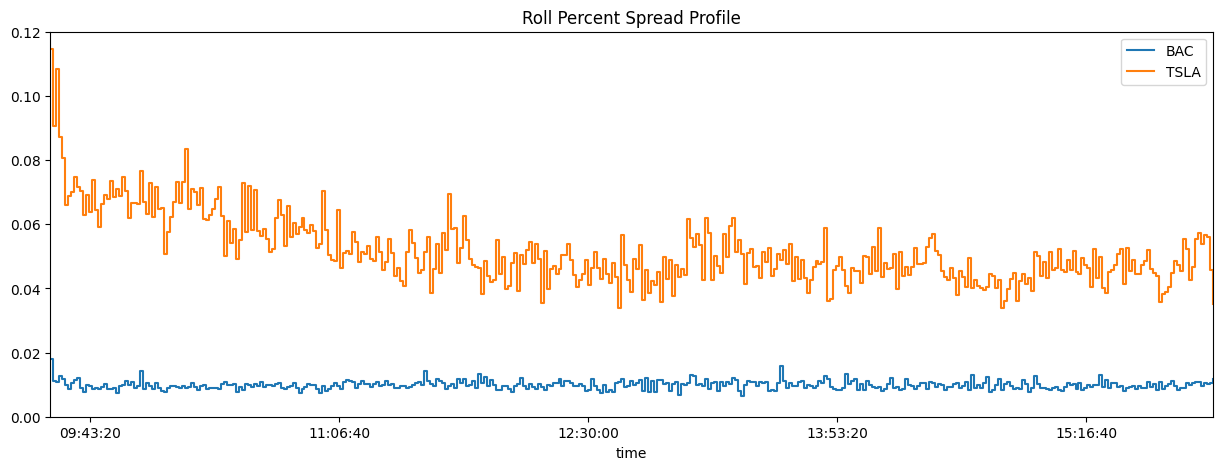

In [26]:
%%py
rp.plot(drawstyle='steps-post',ylim=(0),title='Roll Percent Spread Profile')


### Part G (2 Points)

Roll's spread assumes the distribution of price changes are
stationary.  This would indicate that using daily data should generate
a similar spread calculation as our minutely calculation. Using the
`daily` table, we can generate a spread calculation for the month of
September.

Complete the `dailyquery` function so that it selects daily
information for a list of stocks for the given date range.

Given a start date, end date and list of symbols, return a table with
the date, sym and close columns.


In [27]:
/ (s)tart (d)ate, (e)nd (d)ate, (s)yms
dailyquery:{[sd;ed;s]
 t:select date, sym, close from daily where date within(sd;ed), sym in s;
 t}

In [28]:
/ pass function to database for execution
h (dailyquery;2020.02.03;2020.02.28;`BAC`TSLA)

date       sym  close
---------------------
2020.02.03 BAC  32.93
2020.02.03 TSLA 766  
2020.02.04 BAC  33.58
2020.02.04 TSLA 904  
2020.02.05 BAC  34.75
..


In [29]:
/ confirm all columns are included
assert[1b] all `date`close in cols h (dailyquery;2020.02.03;2020.02.03;`BAC)
/ confirm query only selects specified dates
assert[2020.02.03 2020.02.28] (min;max)@\:exec date from h (dailyquery;2020.02.03;2020.02.29;`BAC)
assert[2020.02.12 2020.02.14] (min;max)@\:exec date from h (dailyquery;2020.02.12;2020.02.15;`BAC)
/ confirm only requested syms have been returned
assert[1#`BAC] exec distinct sym from h (dailyquery;2020.02.03;2020.02.29;`BAC)
assert[`BAC`TSLA] exec distinct sym from h (dailyquery;2020.02.03;2020.02.29;`BAC`TSLA)

### Part H (2 Points)

We can now write a function to compute Roll's effective percent spread
for each sym over the dates in the table.

The function should return a table with two columns (sym and spread).

Complete the `symroll` function so that it computes Roll's effective
percent spread for each sym over all dates in the provided (t)able.

If written correctly, you will notice that BAC and GOOG produces a
null spread.  What went wrong with the calculation?  What can be done
to fix this problem?


In [30]:
/ (t)able with `close and `sym columns
symroll:{[t]
 t:select spread:rollpct close by sym from t;
 t}

In [31]:
show sprd:symroll h (dailyquery;2020.02.03;2020.02.28;`BAC`TSLA`GOOG)

In [32]:
/ confirm all columns are included
assert[1b] all `sym`spread in cols sprd
/ confirm the table schema is correct
assert["sf"] value[meta sprd]`t
/ confirm the table row count is correct
assert[3] count sprd
/ confirm the numbers are accurate
assert[9.7] rnd[.01] avg exec spread from sprd
/ confirm `BAC has a null spread
assert[0n] sprd[`BAC;`spread]

### Part I (2 Points)

We now introduce the quote sizes into our analysis.

Complete the `nbboquery` function so that it selects NBBO information
for a single stock across multiple days.

Given a start date, end date, start time, end time and symbol(s),
return a table with all of the columns from the `nbbo` table.


In [33]:
/ (s)tart (d)ate, (e)nd (d)ate, (s)tart (t)ime;(e)nd (t)ime, (s)ym
nbboquery:{[sd;ed;st;et;s]
 t:select from nbbo where date within(sd;ed), sym in s, time within(st;et);
 t}

In [34]:
/ pass function to database for execution
h (nbboquery;2020.02.03;2020.02.03;09:30;09:35;`BAC)

date       sym time                 bid bsize ask   asize
---------------------------------------------------------
2020.02.03 BAC 0D09:30:00.047182238 33  3     33.04 4    
2020.02.03 BAC 0D09:30:00.059454636 33  4     33.04 4    
2020.02.03 BAC 0D09:30:00.059499987 33  4     33.03 1    
2020.02.03 BAC 0D09:30:00.059860459 33  4     33.03 2    
2020.02.03 BAC 0D09:30:00.222195293 33  3     33.03 2    
..


In [35]:
/ confirm all columns are included
assert[`date`sym`time`bid`bsize`ask`asize] cols h (nbboquery;2020.02.01;2020.02.01;09:30;09:35;`BAC)
/ confirm query only selects specified dates
assert[2] count exec distinct date from h (nbboquery;2020.02.03;2020.02.04;09:30;09:35;`BAC)
/ confirm only requested sym has been returned
assert[1#`BAC] exec distinct sym from h (nbboquery;2020.02.03;2020.02.03;09:30;09:35;`BAC)
assert[`BAC`TSLA] exec distinct sym from h (nbboquery;2020.02.01;2020.02.03;09:30;09:35;`BAC`TSLA)
/ confirm only data within the expected time range is returned
assert[1b] all within[;09:30 09:35]exec time from h (nbboquery;2020.02.03;2020.02.03;09:30;09:35;`BAC)
assert[1b] all within[;09:30 09:40]exec time from h (nbboquery;2020.02.03;2020.02.03;09:30;09:40;`BAC)

In [36]:
/ check that the function is implemented efficiently
assert[1b] 84549088>=0N!last h (timeit;nbboquery;(2020.02.01;2020.02.03;09:30;09:35;`BAC`TSLA))

### Part J (3 Points)

Using the NBBO data, we would like to see how the average quote size
changes over the course of the trading day.

Complete the `quoteprofile` function which:

1. Adds a duration column which computes the time difference between
   the quote and the previous quote within each date/sym.
2. Computes the duration weighted average `bid` and `ask` notional
   (again, for comparability across stocks and dates with corporate
   actions) within each minute/sym of each date
3. Averages each minute's bid and ask notionals across dates.
4. Returns a table with four columns (time, sym, bid and ask) and
   780 rows - one for each minute.

NOTE: Since you will be using the previous quote for each duration,
the first quote in each minute will not be available.


In [37]:
/ pass function to database for execution
show n:h (nbboquery;2020.02.04;2020.02.09;st;et;sym)

In [38]:
/ given a table n (which is expected to have the columns `date`time`asize`bsize)
/ generate a minutely quote profile
quoteprofile:{[n]
 n:update duration:deltas time by date, sym from n;
 n:select bid:duration wavg prev[bsize]*prev[bid], ask:duration wavg prev[asize]*prev[ask] by date, sym, time:0D00:01 xbar time from n;
 n:select avg bid, avg ask by time, sym from n;
 n}

In [39]:
/ build a bid+ask quote size profile
show qp:quoteprofile n
.pykx.set[`qp] .pykx.topd pivot 2!select time,sym,ba:bid+ask from qp

In [40]:
/ confirm all columns are included
assert[`time`sym`bid`ask] cols qp
/ confirm the table row count is correct
assert[780] count qp
/ confirm there are 390 minutes in a day
assert[390] count distinct key[qp]`time
/ confirm the computed quote profile calculations
assert[11270.51 11426.05] rnd[.01] avg each value[qp]`ask`bid

In [41]:
/ check that the function is implemented efficiently
assert[1b] 1073752592>=0N!last system "ts quoteprofile n"

<Axes: title={'center': 'Quote Size Profile'}, xlabel='time'>

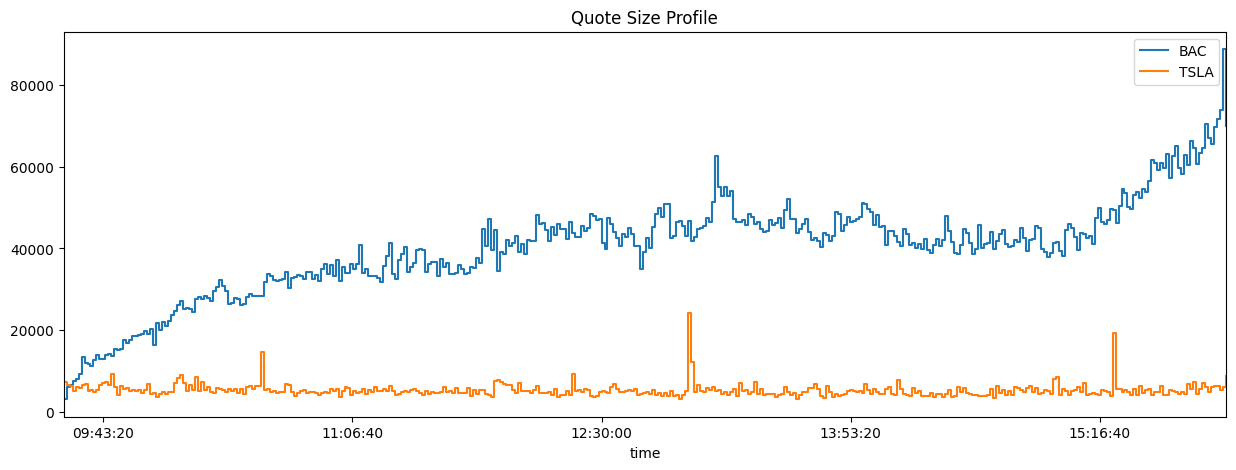

In [42]:
%%py
qp.plot(drawstyle='steps-post',title='Quote Size Profile')


### Part K (3 Points)

Roll's effective spread gave us a profile that would be expected from a
market maker.  Let's see what the spread looks like from a market
taker.  Using the NBBO data, we can see how the average quote spread
changes over the course of the trading day.

Complete the `nspreadprofile` function which:

1. Adds a duration column which computes the time difference between
   the quote and the previous quote within each date/sym.
2. Computes the time weighted average *percent* spread (100*spread/mid)
   within each minute/sym of each date
3. Averages each minute/sym's *percent* spread across dates.

The resulting table should have two columns (time and spread) and
390 rows - one for each minute.

NOTE: Since you will be using the previous spread for each duration,
the first spread in each minute will not be available.


In [43]:
/ given a table n (which is expected to have the columns `date`time`asize`bsize)
/ generate a minutely volume profile
nspreadprofile:{[n]
 n:update duration:deltas time by date, sym from n;
 n:select spread:duration wavg 100*prev[ask-bid]%prev[0.5*bid+ask] by date, sym, time:0D00:01 xbar time from n;
 n:select avg spread by time, sym from n;
 n}

In [44]:
/ build a spread profile
show nsp:nspreadprofile n
.pykx.set[`nsp] .pykx.topd pivot nsp

In [45]:
/ confirm all columns are included
assert[`time`sym`spread] cols nsp
/ confirm the table schema is correct
assert["nsf"] value[meta nsp]`t
/ confirm the table row count is correct
assert[780] count nsp
/ confirm there are 390 minutes in a day
assert[390] count distinct key[nsp]`time
/ confrim the computed volume profile calculations
assert[0.0716] rnd[1e-4] avg value[nsp]`spread

In [46]:
/ check that the function is implemented efficiently
assert[1b] 1073752592>=0N!last system "ts nspreadprofile n"

<Axes: title={'center': 'NBBO Percent Spread Profile'}, xlabel='time'>

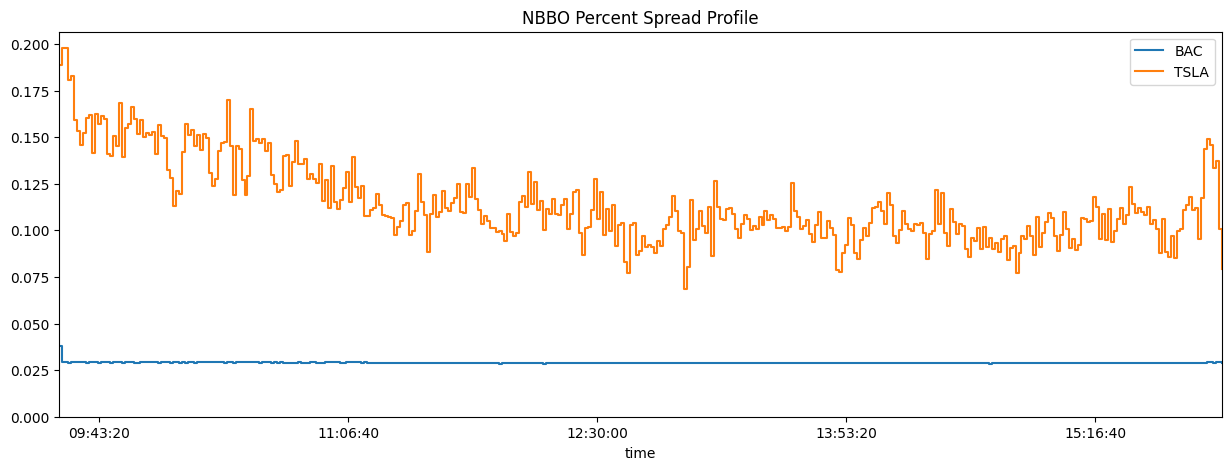

In [47]:
%%py
nsp.plot(drawstyle='steps-post',ylim=(0),title='NBBO Percent Spread Profile')
